In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys

In [3]:
base_path = pathlib.Path(os.getcwd())
base_path = str(base_path.parent)
sys.path = [base_path] + sys.path

In [4]:
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from IPython.display import SVG

In [6]:
seed = 6902

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed)

In [7]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.0, color_codes=True)

In [8]:
os.makedirs("./img/", exist_ok=True)

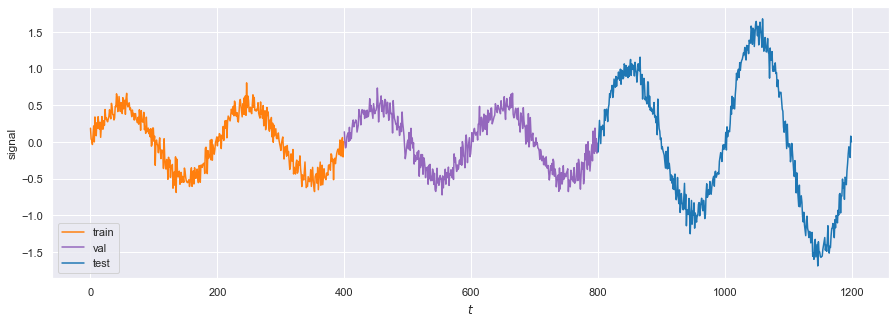

In [9]:
true_sd = 1.0 / 10.0

train_t = np.arange(400)
train_X = 0.5 * np.sin(0.01 * np.pi * train_t)
train_X += np.random.randn(train_X.size) * true_sd

val_t = np.arange(400)
val_X = 0.5 * np.sin(0.01 * np.pi * val_t)
val_X += np.random.randn(val_X.size) * true_sd

test_t = np.arange(200)
test_X1 = 1.0 * np.sin(0.01 * np.pi * test_t)
test_X1 += np.random.randn(test_X1.size) * true_sd
test_t = np.arange(200)
test_X2 = 1.5 * np.sin(0.01 * np.pi * test_t)
test_X2 += np.random.randn(test_X2.size) * true_sd

X = np.r_[train_X, val_X, test_X1, test_X2]
t = np.arange(len(X))
num_train = len(train_t)
num_val = len(val_t)
num_test = len(X) - num_train - num_val

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t[:len(train_X)], X[:len(train_X)], color='tab:orange', label='train')
ax.plot(t[len(train_X):len(train_X)+len(val_X)], X[len(train_X):len(train_X)+len(val_X)], color='tab:purple', label='val')
ax.plot(t[len(train_X)+len(val_X):], X[len(train_X)+len(val_X):], color='tab:blue', label='test')
ax.set_xlabel(r'$t$')
ax.set_ylabel('signal')
ax.legend(loc='lower left')

In [10]:
batch_size = 64
num_timesteps = 30
num_features = 1

X = X.reshape((-1, num_features))
train_gen = TimeseriesGenerator(X, X, num_timesteps, end_index=num_train-1, batch_size=batch_size, shuffle=True)
val_gen = TimeseriesGenerator(X, X, num_timesteps, start_index=num_train, end_index=num_train+num_val-1, batch_size=batch_size, shuffle=False)
test_gen = TimeseriesGenerator(X, X, num_timesteps, end_index=num_train+num_val+num_test-1, batch_size=batch_size, shuffle=False)
test_gen = np.concatenate([x for x, y in test_gen])

In [11]:
n_hidden = 32
drop_rate = 1. - 0.90
recurrent_drop_rate = 1. - 0.90

inputs = keras.Input((num_timesteps, num_features))
lstm = layers.LSTM(n_hidden, activation='tanh', recurrent_activation='sigmoid', dropout=drop_rate, recurrent_dropout=recurrent_drop_rate, implementation=1)(inputs)
output = layers.Dense(1, activation='linear')(lstm)
model = keras.Model(inputs=inputs, outputs=output)

In [12]:
epochs = 300

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto', restore_best_weights=True)

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

model.fit(train_gen,
          epochs=epochs,
          verbose=1,
          validation_data=val_gen,
          callbacks=[es])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 6 steps
Epoch 1/300
6/6 [==============================] - 3s 559ms/step - loss: 0.1390 - val_loss: 0.1083
Epoch 2/300
6/6 [==============================] - 0s 29ms/step - loss: 0.0888 - val_loss: 0.0691
Epoch 3/300
6/6 [==============================] - 0s 29ms/step - loss: 0.0624 - val_loss: 0.0373
Epoch 4/300
6/6 [==============================] - 0s 30ms/step - loss: 0.0375 - val_loss: 0.0217
Epoch 5/300
6/6 [==============================] - 0s 27ms/step - loss: 0.0340 - val_loss: 0.0220
Epoch 6/300
6/6 [==============================] - 0s 27ms/step - loss: 0.0293 - val_loss: 0.0198
Epoch 7/300
6/6 [==============================] - 0s 32ms/step - loss: 0.0287 - val_loss: 0.0209
Epoch 8/300
6/6 [==============================] - 0s 33ms/step - loss: 0.0272 - val_loss: 0.0206
Epoch 9/300
6/6 [==============================] - 0s 29ms/step - loss: 0.0276 - val_loss: 0.0193
Epoch 10/300
6/6 [=========

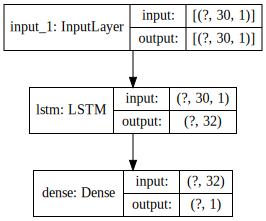

In [13]:
model_to_dot(model, show_shapes=True).write_pdf("img/series_architecture-nn.pdf")
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

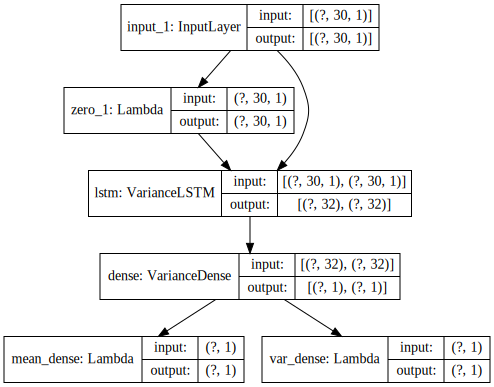

In [14]:
from vpbnn.models import nn2vpbnn
vmodel = nn2vpbnn(model, variance_mode=2)
model_to_dot(vmodel, show_shapes=True).write_pdf("img/series_architecture-vpbnn.pdf")
SVG(model_to_dot(vmodel, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

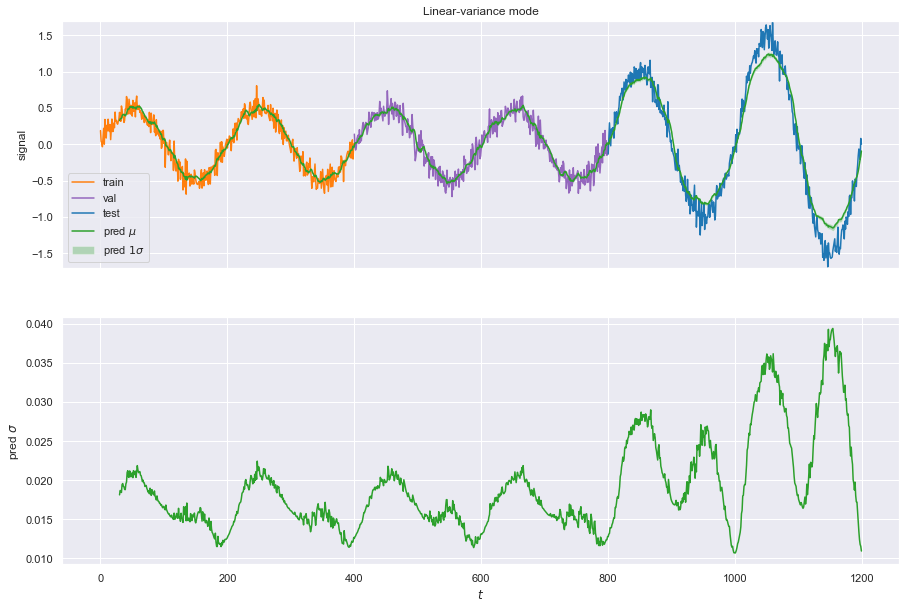

In [15]:
vmodel = nn2vpbnn(model, 1)

pred_mean, pred_var = vmodel.predict(test_gen)
pred_mean = pred_mean.ravel()
pred_std = np.sqrt(pred_var.ravel())

fig, (ax1, ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax1.plot(t[:len(train_X)], X[:len(train_X)], color="tab:orange", label="train")
ax1.plot(t[len(train_X):len(train_X)+len(val_X)], X[len(train_X):len(train_X)+len(val_X)], color="tab:purple", label="val")
ax1.plot(t[len(train_X)+len(val_X):], X[len(train_X)+len(val_X):], color="tab:blue", label="test")
ax1.plot(t[-len(pred_mean):], pred_mean, "tab:green", label=r"pred $\mu$")
ax1.fill_between(t[-len(pred_mean):], pred_mean + 1. * pred_std, pred_mean - 1. * pred_std, facecolor="tab:green", alpha=0.3, label=r"pred $1 \sigma$")
ax1.set_ylabel("signal")
ax1.set_title("Linear-variance mode")
ax1.set_ylim(-1.7, 1.7)
ax1.legend(loc="lower left")

ax2.plot(t[-len(pred_mean):], pred_std, "tab:green")
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"pred $\sigma$")
fig.savefig("img/series_linear-mode.pdf", bbox_inches="tight")

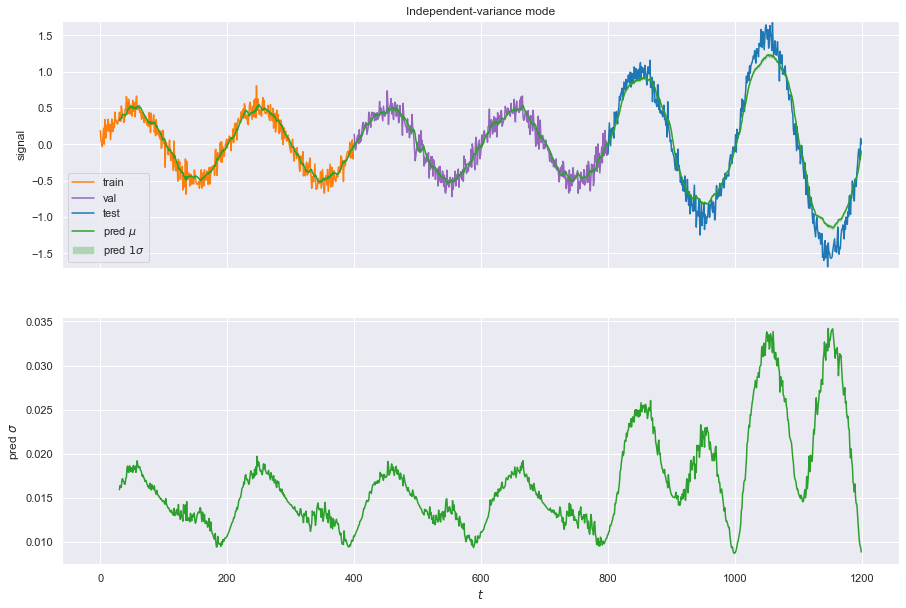

In [16]:
vmodel = nn2vpbnn(model, 2)

pred_mean, pred_var = vmodel.predict(test_gen)
pred_mean = pred_mean.ravel()
pred_std = np.sqrt(pred_var.ravel())

fig, (ax1, ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax1.plot(t[:len(train_X)], X[:len(train_X)], color="tab:orange", label="train")
ax1.plot(t[len(train_X):len(train_X)+len(val_X)], X[len(train_X):len(train_X)+len(val_X)], color="tab:purple", label="val")
ax1.plot(t[len(train_X)+len(val_X):], X[len(train_X)+len(val_X):], color="tab:blue", label="test")
ax1.plot(t[-len(pred_mean):], pred_mean, "tab:green", label=r"pred $\mu$")
ax1.fill_between(t[-len(pred_mean):], pred_mean + 1. * pred_std, pred_mean - 1. * pred_std, facecolor="tab:green", alpha=0.3, label=r"pred $1 \sigma$")
ax1.set_ylabel("signal")
ax1.set_title("Independent-variance mode")
ax1.set_ylim(-1.7, 1.7)
ax1.legend(loc="lower left")

ax2.plot(t[-len(pred_mean):], pred_std, "tab:green")
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"pred $\sigma$")
fig.savefig("img/series_independent-mode.pdf", bbox_inches="tight")

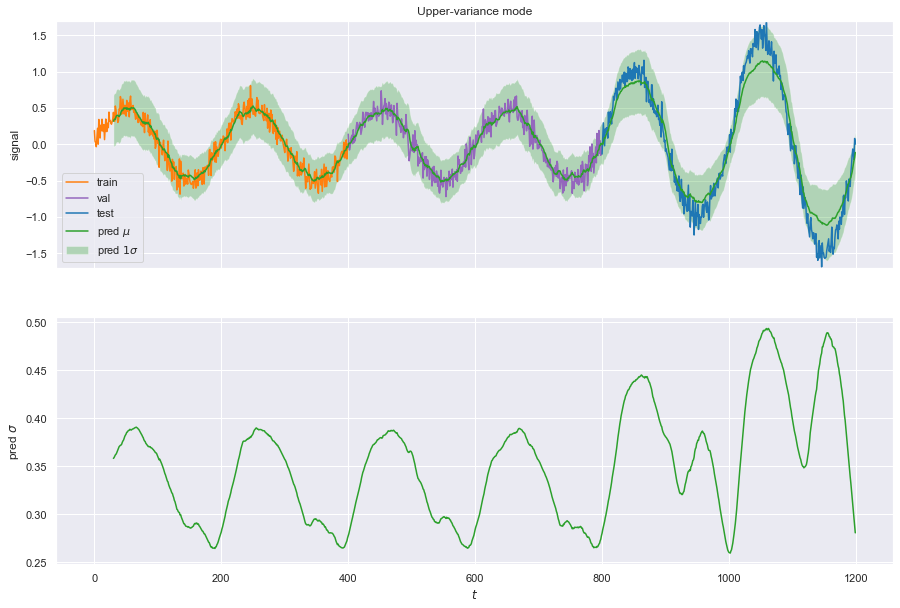

In [17]:
vmodel = nn2vpbnn(model, 3)

pred_mean, pred_var = vmodel.predict(test_gen)
pred_mean = pred_mean.ravel()
pred_std = np.sqrt(pred_var.ravel())

fig, (ax1, ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax1.plot(t[:len(train_X)], X[:len(train_X)], color='tab:orange', label='train')
ax1.plot(t[len(train_X):len(train_X)+len(val_X)], X[len(train_X):len(train_X)+len(val_X)], color='tab:purple', label='val')
ax1.plot(t[len(train_X)+len(val_X):], X[len(train_X)+len(val_X):], color='tab:blue', label='test')
ax1.plot(t[-len(pred_mean):], pred_mean, 'tab:green', label=r'pred $\mu$')
ax1.fill_between(t[-len(pred_mean):], pred_mean + 1. * pred_std, pred_mean - 1. * pred_std, facecolor='tab:green', alpha=0.3, label=r'pred $1 \sigma$')
ax1.set_ylabel('signal')
ax1.set_title("Upper-variance mode")
ax1.set_ylim(-1.7, 1.7)
ax1.legend(loc='lower left')

ax2.plot(t[-len(pred_mean):], pred_std, 'tab:green')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'pred $\sigma$')
fig.savefig("img/series_upper-mode.pdf", bbox_inches="tight")

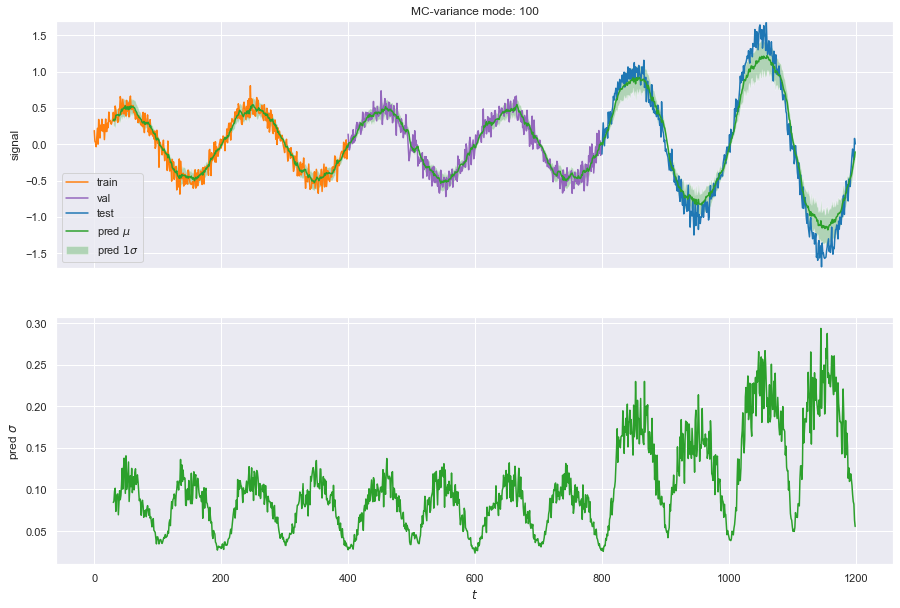

In [18]:
vmodel = nn2vpbnn(model, 4)

num_mc = 100
y_preds = []
for _ in range(num_mc):
    pred, _ = vmodel.predict(test_gen)
    pred = pred.ravel()
    y_preds.append(pred)

pred_mean = np.mean(y_preds, axis=0)
pred_std = np.std(y_preds, axis=0)
    
fig, (ax1, ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax1.plot(t[:len(train_X)], X[:len(train_X)], color='tab:orange', label='train')
ax1.plot(t[len(train_X):len(train_X)+len(val_X)], X[len(train_X):len(train_X)+len(val_X)], color='tab:purple', label='val')
ax1.plot(t[len(train_X)+len(val_X):], X[len(train_X)+len(val_X):], color='tab:blue', label='test')
ax1.plot(t[-len(pred_mean):], pred_mean, 'tab:green', label=r'pred $\mu$')
ax1.fill_between(t[-len(pred_mean):], pred_mean + 1. * pred_std, pred_mean - 1. * pred_std, facecolor='tab:green', alpha=0.3, label=r'pred $1 \sigma$')
ax1.set_ylabel('signal')
ax1.set_title("MC-variance mode: {0}".format(num_mc))
ax1.set_ylim(-1.7, 1.7)
ax1.legend(loc='lower left')

ax2.plot(t[-len(pred_mean):], pred_std, 'tab:green')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'pred $\sigma$')
fig.savefig("img/series_mc-mode.pdf", bbox_inches="tight")

In [19]:
vmodel = nn2vpbnn(model, variance_mode=4)  # MC-mode
pmodel = keras.Model(inputs=vmodel.input, outputs=vmodel.layers[2].output[0])

num_mc = 500
y_preds = []
for _ in range(num_mc):
    predict = pmodel.predict(test_gen)
    y_preds.append(predict)

In [20]:
y_preds = np.transpose(np.array(y_preds), (1, 0, 2))

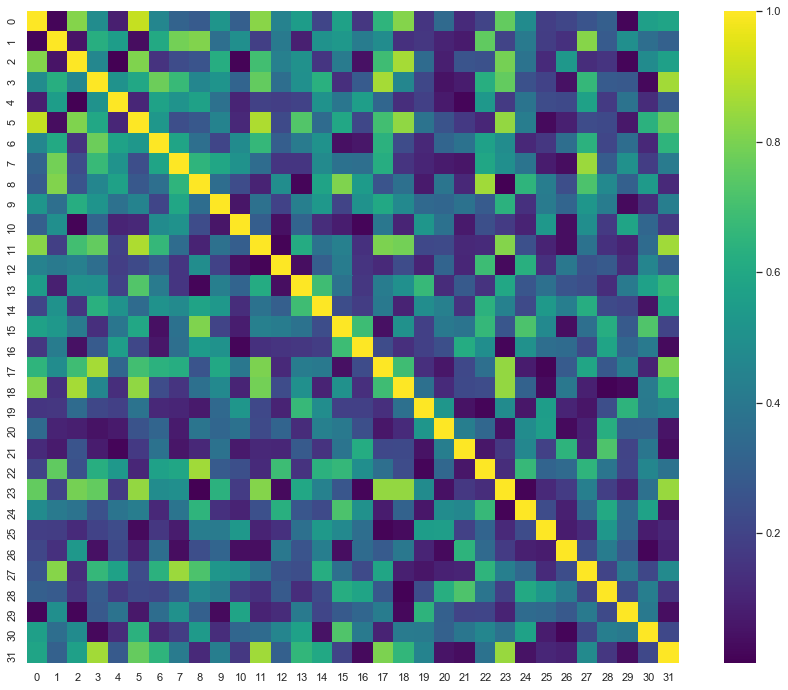

In [21]:
df = pd.DataFrame(y_preds[700, ...])
corr = df.corr()
corr[np.isnan(corr)] = 0.0
corr = np.abs(corr)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corr, cmap="viridis", square=True, ax=ax)

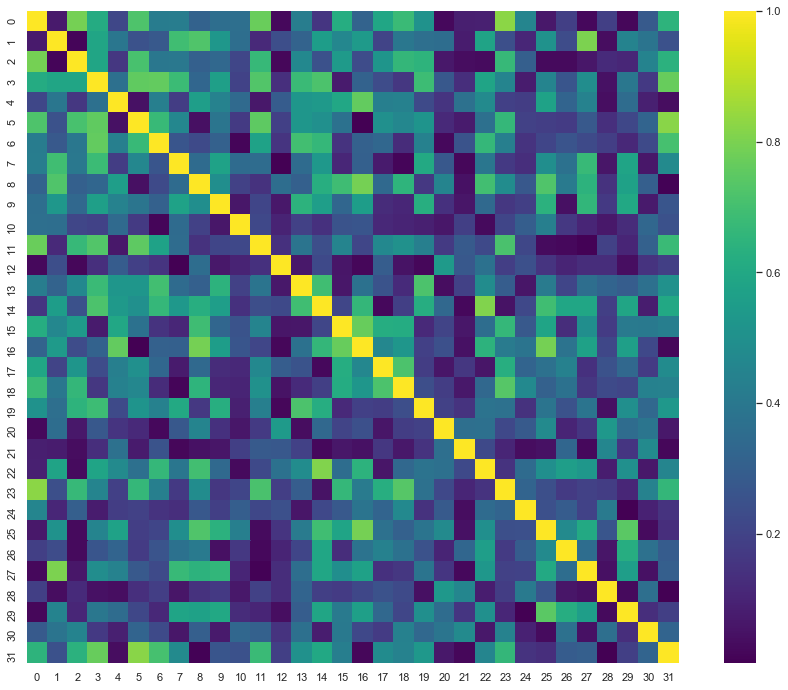

In [22]:
df = pd.DataFrame(y_preds[800, ...])
corr = df.corr()
corr[np.isnan(corr)] = 0.0
corr = np.abs(corr)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corr, cmap="viridis", square=True, ax=ax)

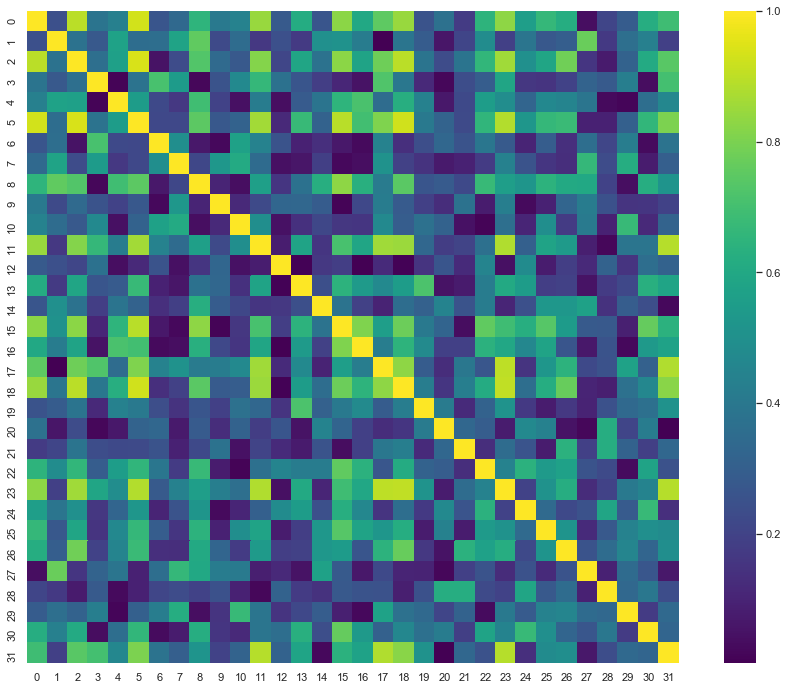

In [23]:
df = pd.DataFrame(y_preds[900, ...])
corr = df.corr()
corr[np.isnan(corr)] = 0.0
corr = np.abs(corr)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corr, cmap="viridis", square=True, ax=ax)

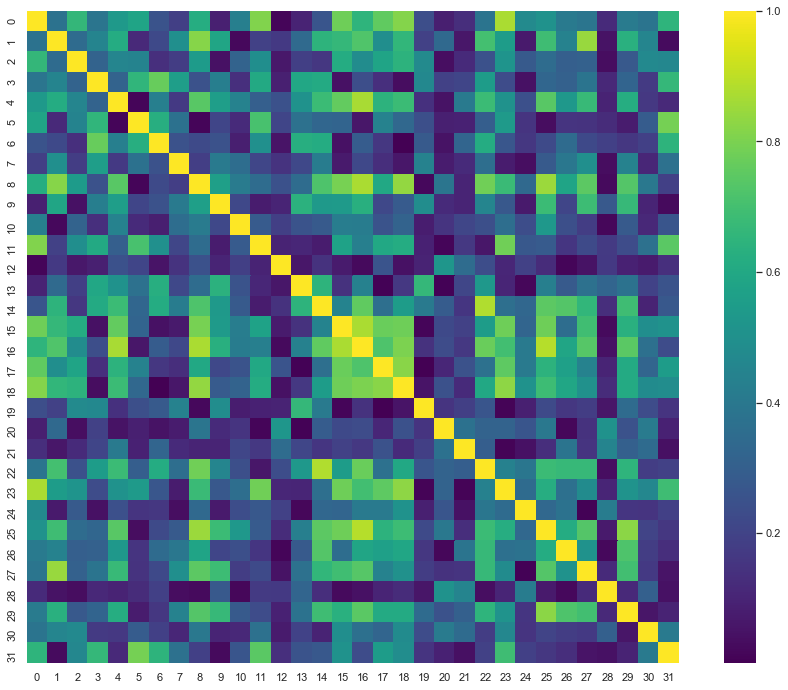

In [24]:
df = pd.DataFrame(y_preds[1000, ...])
corr = df.corr()
corr[np.isnan(corr)] = 0.0
corr = np.abs(corr)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corr, cmap="viridis", square=True, ax=ax)